In [5]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import preprocessing as pp
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [7]:
# Load the data
df = pd.read_csv('/home/violett/Downloads/exam_module_4/3_variant_nasa_danger_objects/input/v2_second_collection_2022.csv')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [8]:
df.shape#Посмотрим из скольких строк состоит наш объект

(90836, 10)

In [9]:
df.isnull().sum()#Проверим сколько пустых ячеек у нас есть

id                    0
name                  0
est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
orbiting_body         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [10]:
# Так как у нас по одному пропущеному значению, думаю не страшно если мы их просто удалим
df_copy = df.copy(deep=True)#Делаем копию данных
df_copy= df.dropna(how='any')#Удалим данные с отсутсвующими значениями

In [11]:
# Рашифруем все категории
# id - номер объекта
# est_diameter_min - минимально измеренный диаметр
# est_diameter_max - максимально измеренный деаметр
#relative_velocity - относительная скорость
# miss_distance - какое-то расстояние?значительно больше остальных переменных
# orbiting_body - орбитальное тело
# sentry_object - часовой объект
#absolute_magnitude - магнитуда 
#hazardous - опасен объект или нет
# 1. Определить тип задачи
# Как я понимаю задача стоит в классификации объекта - опасен он или нет, целевая переменная - hazardous
# Посмотрим есть ли дисбаланс классов


In [12]:
#Количество безопасных\опасных объектов
# Так как присутсвует дисбаланс классов, то задача сводится к поиску анамолий(опасных объектов) в датасете
df_copy['hazardous'].value_counts()

False    81996
True      8840
Name: hazardous, dtype: int64

In [13]:
# Определим тип переменных и их распределение в датасете
# sentry_object и sentry_object имеют 1 уникальное значение никак на датасет влиять эти данные не будут. 
# Name - id так же по логике связанные данные, можно удалить name, плюс номер объекта никак не связан с его особенностями,я надеюсь
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [14]:
df_copy=df_copy.drop(['name'], axis=1)
df_copy=df_copy.drop(['orbiting_body'], axis=1)
df_copy=df_copy.drop(['sentry_object'], axis=1)
df_copy=df_copy.drop(['id'], axis=1)

In [15]:
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df_copy['hazardous']= label_encoder.fit_transform(df_copy['hazardous'])
df_copy.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


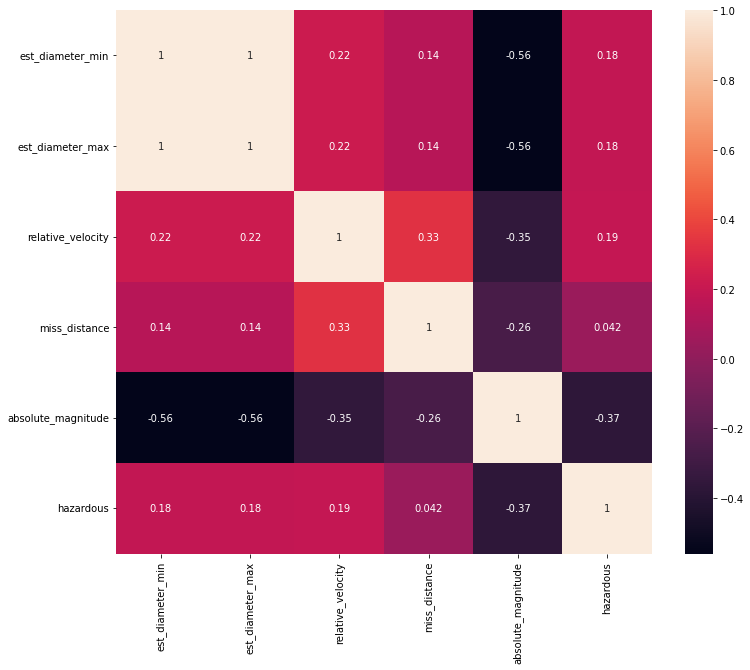

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_copy.corr(), annot=True);
#Видна сильная корреляция между est_diameter_min и est_diameter_max. Удалим одно

In [16]:
df_copy=df_copy.drop(['est_diameter_min'], axis=1)

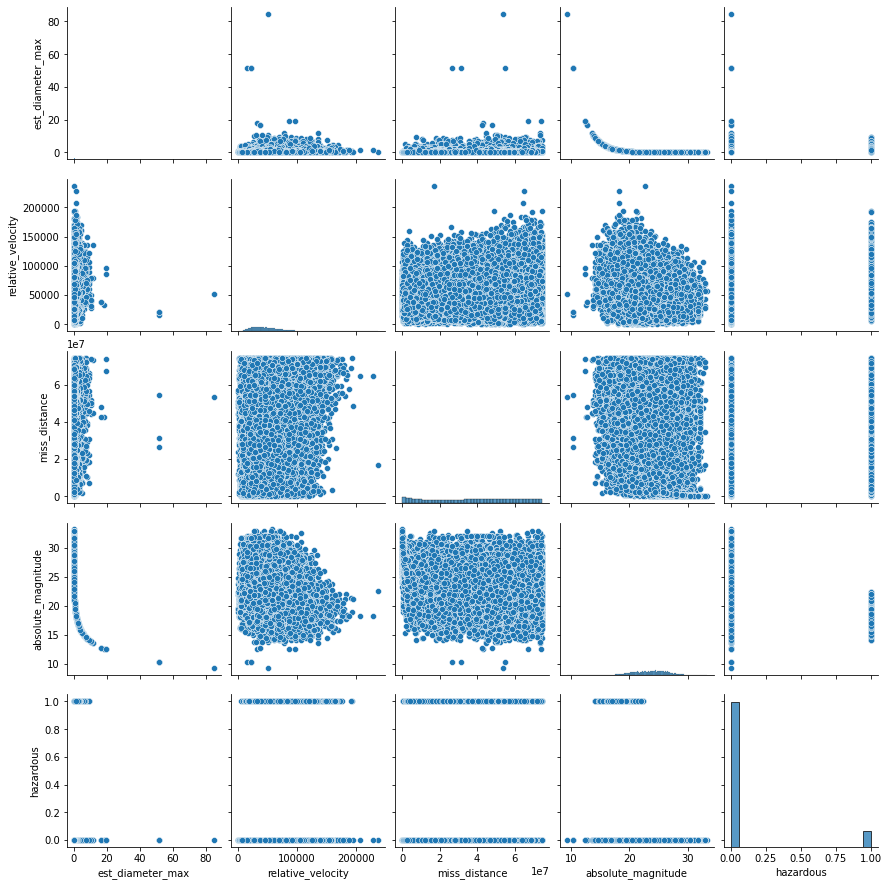

In [26]:
sns.pairplot(df_copy);

In [17]:
# По стандартному процессу разделим нашу выборку
# Split to train and test and scale features
dataX = df_copy.drop(['hazardous'],axis=1)
dataY = df_copy.loc[:,'hazardous'].copy()

X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.1,
                                                    random_state=42, stratify=dataY)


In [18]:
features_to_scale = X_train.columns

scaler_X = pp.StandardScaler(copy=True)

X_train.loc[:,features_to_scale] = scaler_X.fit_transform(X_train.loc[:,features_to_scale])
X_test.loc[:,features_to_scale] = scaler_X.transform(X_test.loc[:,features_to_scale])

In [19]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector",
               y="Second Vector",
               hue="Label",
               data=tempDF,
               fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using " + algoName)

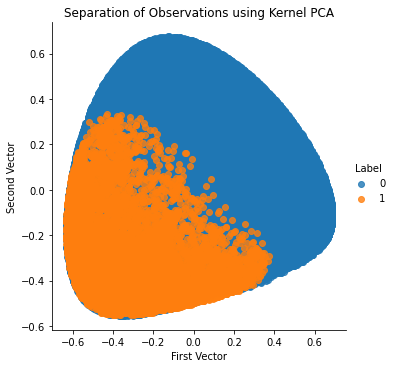

In [17]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 2
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = 42
n_jobs = -1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)

kernelPCA.fit(X_train.iloc[:2000])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

In [18]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [19]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision =  {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'],
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

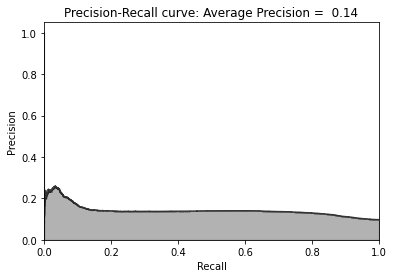

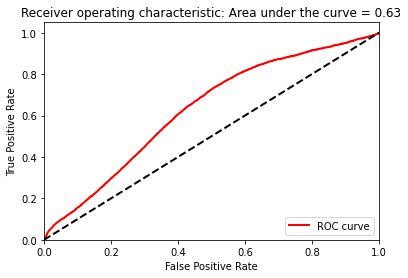

In [20]:
# View plot c учетом дисбаланса классов не очень хороший результат. Попробуем другие
anomalyScoresKernelPCA = anomalyScores(X_train, X_train_kernelPCA_inverse)
preds = plotResults(y_train, anomalyScoresKernelPCA, True)

In [20]:
 from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_

array([0.48708343, 0.24183845, 0.16533139, 0.10574672])

In [22]:
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

<Figure size 720x360 with 0 Axes>

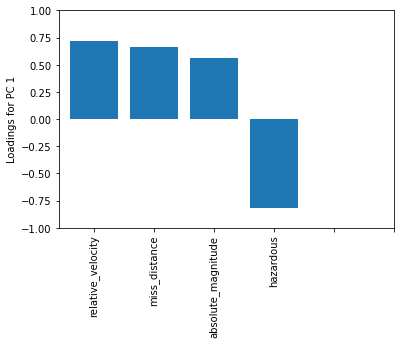

In [24]:
plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
ax.bar(range(4), sklearn_loadings[:, 0], align='center')
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(6))
ax.set_xticklabels(df_copy.columns[1:], rotation=90)
plt.ylim([-1, 1])
plt.show()
# Как видно из графика наибольшее влияние вносит такой параметр как скорость. Меньше всего влияет absolute_magnitude.
#Все оставшиеся параметры имеют сильное влияние на разрушительное действие объекта

In [25]:
#Попробуем по другому найти все наши аномальрные значения. Для этого используем isolated forest
# Попробовала поискать оптимальные значения через гридсерч
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification

clf = IsolationForest(random_state=42)

param_grid = {'n_estimators': list(range(100, 800, 5)), 
              'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.3, 0.5], 
              'max_features': [5,10,15], 
              'bootstrap': [True, False], 
              'n_jobs': [-1]}

f1sc = make_scorer(f1_score, average='micro')

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=10, 
                                                 return_train_score=True)
grid_dt_estimator.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [33]:
df_copy['scores']=model.decision_function(df_copy[['hazardous']])
df_copy['anomaly']=model.predict(df_copy[['hazardous']])
df_copy.head(20)

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,scores,anomaly
0,2.679415,13569.249224,5.483974e+07,16.73,0,0.000000,1
1,0.594347,73588.726663,6.143813e+07,20.00,1,-0.175898,-1
2,1.614507,114258.692129,4.979872e+07,17.83,0,0.000000,1
3,0.215794,24764.303138,2.543497e+07,22.20,0,0.000000,1
4,0.570217,42737.733765,4.627557e+07,20.09,1,-0.175898,-1
5,0.081291,34297.587778,4.058569e+07,24.32,0,0.000000,1
6,0.383743,27529.472307,2.906912e+07,20.95,0,0.000000,1
7,0.011914,57544.470083,5.511502e+07,28.49,0,0.000000,1
8,0.783502,56625.210122,6.903598e+07,19.40,0,0.000000,1
9,0.236614,48425.840329,3.835526e+07,22.00,0,0.000000,1


In [34]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples=200, contamination=float(0.5),max_features=1.0)
model.fit( df_copy[['hazardous']])

/home/violett/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.5, max_samples=200, n_estimators=50)

In [35]:
anomaly=df_copy.loc[df_copy['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

       est_diameter_max  relative_velocity  miss_distance  absolute_magnitude  \
1              0.594347       73588.726663   6.143813e+07               20.00   
4              0.570217       42737.733765   4.627557e+07               20.09   
10             0.564989       58430.697200   3.833750e+07               20.11   
23             0.450858      115899.180498   1.510102e+07               20.60   
27             0.247765       48655.305132   3.279775e+07               21.90   
...                 ...                ...            ...                 ...   
90782          0.297879       67595.756852   5.681059e+07               21.50   
90794          0.234444       51149.696785   5.450002e+07               22.02   
90811          0.798068       33008.617883   7.189835e+07               19.36   
90812          2.312278       53362.798148   4.756627e+07               17.05   
90818          1.137732       71465.448580   8.894222e+06               18.59   

       hazardous    scores 

In [39]:
outliers_counter = len(df_copy[df_copy['hazardous'] ==1])
outliers_counter

8840

In [40]:
print("Accuracy percentage:", 100*list(df_copy['anomaly']).count(-1)/(outliers_counter))



Accuracy percentage: 100.0
